***DEEP LEARNING MODEL FROM SCRATCH***

**In this notebook we are going to explain the execution of a deep learning regression model built from scratch. The objective of the model is to extract QR codes from images using bounding boxes**.

This is notebook was runned on a google collab notebook which allowed us to use CPUs and GPUs for faster computing.

**1. Importing Libraries and Initializing Paths for Obtaining the Data as Explained in the README notebook.**
To built the model we are going to use tensorflow and keras.


In [4]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt


def initial_paths_and_parameters(path):

    """
    Initializes paths and parameters for a machine learning model training process.

    This function takes a 'path' as input and sets up paths for training and testing data, loads annotation files,
    and defines several key parameters for training a machine learning model.
    """

    path_train = path + 'train/'
    path_test = 'test/'
    annotations_file_train =  pd.read_csv(path_train + '_annotations.csv')
    annotations_file_train = annotations_file_train.drop_duplicates(subset = 'filename') #We drop duplicates based on the file name.
    batch_size = 10
    dropout_factor = 0.5
    input_size = 244

    return annotations_file_train, path_train, path_test, batch_size, dropout_factor, input_size

annotations_file_train, path_train, path_test, batch_size, dropout_factor, input_size = initial_paths_and_parameters('/content/drive/MyDrive/juanf/')

print(f'Training data has ',(len(annotations_file_train)), ' images.')

Training data has  502  images.


**2. Preprocess Images Format**

Here we create two functions.


*   The image_format function changes the format of the image. In deep learning, the choice of input image size, such as the common use of 224x224 is typically related to various factors that affect the model's performance and efficiency.
*   The create_data_train_validation function creates an annotated vector in tensorflow format which will be used to train the Deep Learning model.

Train Sample Run
Example Data Set Image with Annotaion:


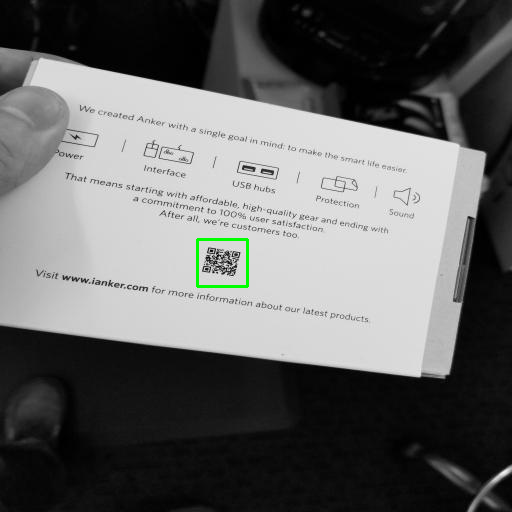

Example Formatted Image with Annotaion:


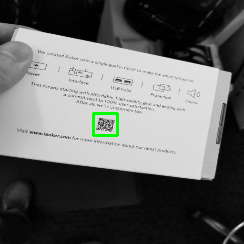

Example Formatted Image without Annotaion:


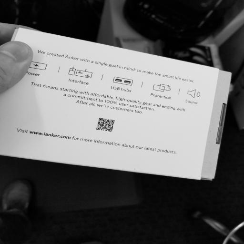

Non Existent Image
Val Sample Run
Example Data Set Image with Annotaion:


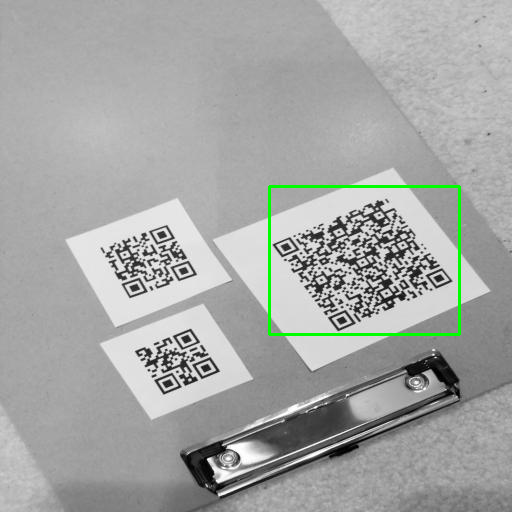

Example Formatted Image with Annotaion:


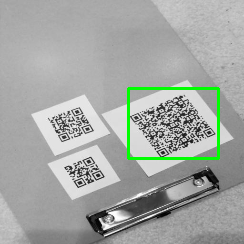

Example Formatted Image without Annotaion:


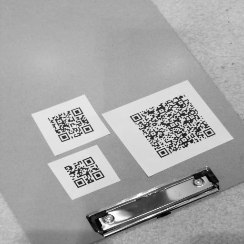

In [6]:
def image_format(img):

    """
    Resize and reformat an image to fit within a specified input size, maintaining aspect ratio.

    Args:
        img (numpy.ndarray): The input image as a NumPy array.

    Returns:
        tuple: A tuple containing:
            - new_image (numpy.ndarray): The resized and reformatted image with dimensions (input_size, input_size).
            - original_width (int): The width of the original image.
            - original_height (int): The height of the original image.
            - new_width (int): The width of the resized image.
            - new_height (int): The height of the resized image.
    """

    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)

    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    return (new_image, width, height, new_width, new_height)

def create_data_train_validation(path, annotations_file_train, input_size):

  """
  Create a dataset for training and validation from images and corresponding annotations.

  Args:
      path (str): The path to the directory containing the images.
      annotations_file_train (pandas.DataFrame): DataFrame containing annotations for training data.

  Returns:
      tf.data.Dataset: A TensorFlow dataset containing pairs of preprocessed images and corresponding labels.

  Notes:
      - The function assumes that the image files are grayscale.
      - The function requires the 'image_format' function to be defined and available.
  """

  X=[]
  Y=[]

  range_for_loop =len(annotations_file_train)
  for j in range(0,range_for_loop):

    indexes = list(annotations_file_train.index)
    i = indexes[j]
    img = cv2.imread(path + annotations_file_train.loc[i,'filename'], cv2.IMREAD_GRAYSCALE)

    #This Try is done in order to omit images that were annotated but are not in the data set.
    try:
      #Image Formatting
      new_image, width, height, new_width, new_height = image_format(img)
      x = annotations_file_train.loc[i,'xmin']
      y = annotations_file_train.loc[i,'ymin']
      w = (annotations_file_train.loc[i,'xmax'] - x)
      h = (annotations_file_train.loc[i,'ymax'] - y)
      old_box = [x, y, w, h]

      xmin = annotations_file_train.loc[i,'xmin']
      ymin = annotations_file_train.loc[i,'ymin']
      xmax = (annotations_file_train.loc[i,'xmax'])
      ymax = (annotations_file_train.loc[i,'ymax'])

      w_scale = new_width/width
      h_scale = new_height/width
      new_x_min = int(xmin * w_scale)
      new_y_min = int(ymin * h_scale)
      new_x_max = int(xmax * w_scale) - new_x_min
      new_y_max = int(ymax * h_scale) - new_y_min
      new_box = [new_x_min, new_y_min, new_x_max, new_y_max]

      color_img_new = cv2.cvtColor(new_image, cv2.COLOR_GRAY2RGB)
      color_try  = color_img_new.copy()

      #Show examples of images that go into the model
      if j == 0:
        color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        rect_img = cv2.rectangle(color_img, old_box, (0, 255, 0), 2)
        rect_img_new = cv2.rectangle(color_try, new_box, (0, 255, 0), 2)
        print('Example Data Set Image with Annotaion:')
        cv2_imshow(rect_img)
        print('Example Formatted Image with Annotaion:')
        cv2_imshow(rect_img_new)
        print('Example Formatted Image without Annotaion:')
        cv2_imshow(color_img_new)


      new_image = new_image.astype(float)/ 255.
      new_box = np.asarray(new_box, dtype = float) / input_size
      label = np.append(new_box,1)

      #Save the result in variables
      X.append(new_image)
      Y.append(label)

    except:
      print('Non Existent Image')

  #Assign the variables to tensors.
  X = np.array(X)
  X = np.expand_dims(X, axis = 3)
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  Y = tf.convert_to_tensor(Y, dtype=tf.float32)
  result = tf.data.Dataset.from_tensor_slices((X, Y))

  return result

#We split the train and validation data

def train_val_split(annotations_file_train, frac = 0.9):

  train_sample = annotations_file_train.sample(frac = frac, random_state = 42)
  validation_sample = annotations_file_train[~annotations_file_train.index.isin(train_sample.index)]

  return train_sample, validation_sample

train_sample, validation_sample = train_val_split(annotations_file_train)
print('Train Sample Run')
train_data_tf = create_data_train_validation(path_train, train_sample, input_size)
print('Val Sample Run')
validation_data_tf = create_data_train_validation(path_train, validation_sample, input_size)

**In the above images we can see how they were preprocessed and annotated.**

1.   The first image corresponds to the original image
2.   The second image correspond to the new formatted image with the respective annotation.
3. The third image is the one that is going to be given to the model for training and validation



**3. Format Data to Tensorflow Perfomance**

In this section we tune our data in order to increase the deep learning model performance.


In [7]:
def format_instance(image, label):

    """
    Format an image-label pair for a specific task.

    This function takes an input image and label and returns them in a modified format
    suitable for a specific task. In this case, it reformats the label from [x, y, width, height]
    to a tuple of individual components.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.
        label (list or tuple): The label associated with the image, usually in the format [x, y, width, height].

    Returns:
        tuple: A tuple containing the input image and a modified label format:
            - image (numpy.ndarray): The input image.
            - label_tuple (tuple): A tuple containing individual components of the label: (x, y, width, height).
    """
    return image, ([label[0], label[1], label[2], label[3]])

def tune_training_ds(dataset, batch_size):

    """
    Tune a TensorFlow dataset for training.

    This function performs various preprocessing steps to prepare a TensorFlow dataset
    for training a machine learning model. It applies data mapping, shuffling, batching,
    and repeating to optimize the dataset for training.

    Args:
        dataset (tf.data.Dataset): The input TensorFlow dataset.

    Returns:
        tf.data.Dataset: A tuned TensorFlow dataset suitable for training.
    """
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1230, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

def tune_validation_ds(dataset, batch_size):

    """
    Tune a TensorFlow dataset for validation.

    This function performs preprocessing steps to prepare a TensorFlow dataset for validation
    of a machine learning model. It applies data mapping, batching, and optional repetition
    to optimize the dataset for validation.

    Args:
        dataset (tf.data.Dataset): The input TensorFlow dataset.

    Returns:
        tf.data.Dataset: A tuned TensorFlow dataset suitable for model validation.
    """
    dataset = dataset.map(format_instance)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset

train_ds = tune_training_ds(train_data_tf, batch_size)
validation_ds = tune_validation_ds(validation_data_tf, batch_size)

**4. Build Deep Learning Model**

In this section we compile a deep learning CNN architecture. We use a regression neural network to predict the bounding boxes of QR codes

In [8]:

def build_cnn(inputs, dropout_factor):

    """
    Build a CNN architecture for image classification using TensorFlow Keras.

    This function constructs a CNN model with convolutional and fully connected layers
    for image classification tasks.

    Parameters:
    inputs (Tensor): Input tensor for the model, representing images.
    dropout_factor (float): Dropout rate to be applied after convolutional layers.

    Returns:
    Tensor: Output tensor representing the processed features.
    """

    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.MaxPool2D(3,3)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.MaxPool2D(3,3)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(dropout_factor)(x)
    x = tf.keras.layers.MaxPool2D(3,3)(x)

    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    return x

def build_regressor_head(inputs):

    """
    Build a regression head for a neural network using TensorFlow Keras.

    This function constructs a regression head by adding a Dense (fully connected) layer
    with linear activation to the provided input tensor. This is useful for creating
    a neural network that performs regression tasks.

    Parameters:
    inputs (Tensor): Input tensor for the regression head.

    Returns:
    Tensor: Output tensor representing the regression predictions.
    """

    return tf.keras.layers.Dense(units = '4',activation = 'linear' , name = 'regressor_head')(inputs)

def build_model(inputs, learning_rate):

    """
    Build a composite model for regression tasks using TensorFlow Keras.

    This function constructs a composite model by combining a mini-VGG architecture with a
    regressor head for regression tasks. The model is compiled using the Adam optimizer and
    mean squared error (MSE) loss, suitable for regression problems.

    Parameters:
    inputs (Tensor): Input tensor for the model.
    learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
    tf.keras.Model: Compiled composite model for regression.
    """

    cnn_nn = build_cnn(inputs, dropout_factor)
    regressor_head = build_regressor_head(cnn_nn)

    model = tf.keras.Model(inputs = inputs, outputs = [regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = { 'regressor_head' : 'mse' },
              metrics = { 'regressor_head' : 'mse' })

    return model

#We built our model and fit it
learning_rate = 0.001
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)),learning_rate)
model.summary()

epochs = 100
model_deep = model.fit(train_ds,
                    steps_per_epoch=(len(annotations_file_train) // batch_size),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=epochs)
                    #callbacks=[checkpoint_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 10)                595370    
                                                                 
 regressor_head (Dense)      (None, 4)                 44        
                                                                 
Total params: 595,414
Trainable params: 595,414
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 1s 13ms/step - loss: 13.8042 - mse: 13.8042 - val_loss: 0.1576 - val_mse: 0.1576
Epoch 2/100
50/50 [==============================] - 

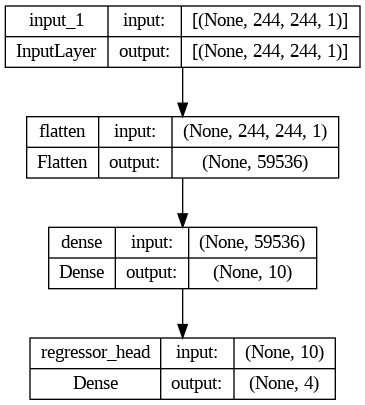

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='scratch_model_plot.png', show_shapes=True, show_layer_names=True)

**5. Plot Metrics**

Once the model is compiled, fitted and validated with our data we proceed to check its results.
Thus, we run a loss and val_loss vs epochs graph.

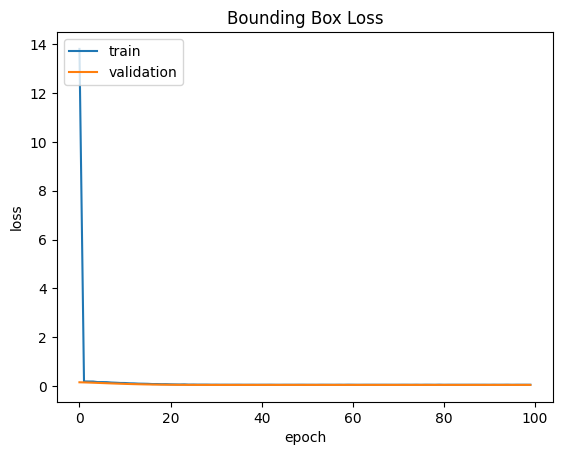

In [10]:
plt.plot(model_deep.history['loss'])
plt.plot(model_deep.history['val_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see how the model is performing as the epochs advance. Thus, the model performs better since it gets smaller values for the loss function.

**Now we proceed to get some values of the intersection over union to understand how is the model performing against validation data**

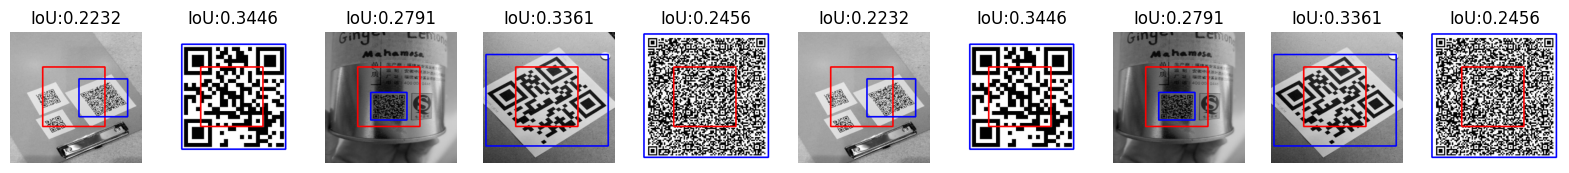

In [53]:
def intersection_over_union(boxA, boxB):

	"""
	Calculate the Intersection over Union (IoU) metric for two bounding boxes.

	Intersection over Union (IoU) is a metric used to evaluate the overlap between
	two bounding boxes. It is commonly used in object detection tasks.

	Parameters:
	boxA (tuple or list): Coordinates of the first bounding box in the format (x1, y1, x2, y2),
												where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner.
	boxB (tuple or list): Coordinates of the second bounding box in the same format.

	Returns:
	float: Intersection over Union (IoU) value, ranging from 0 to 1, where higher values indicate more overlap.
	"""

	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)

	return iou

plt.figure(figsize=(20, 10))
test_list = list(validation_ds.take(10).as_numpy_iterator())
image, labels = test_list[0]
for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]
    predictions = model(image)
    predicted_box = predictions[0] *input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    image = image[0]
    actual_box = labels[0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)
    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    color = (255, 0, 0)

    cv2.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv2.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

**From the results above we see that there is an aproximate value of IoU around 30%. We proceed to export the model and run the pyinstaller function to analyze the model results and see the perfomance of the QR extraction.**

**6. Extract Model**

In [ ]:
model.save('/content/drive/MyDrive/juanf/scratch_deep_learning_model')

Now we proceed to test the model using the API. This results are going to be discussed in the README Notebook. (Notebook finishes here)

****

In [64]:
'''
images_test_files = os.listdir(path_test)

for i in range(0,len(images_test_files)):

  file_image = images_test_files[i]
  img = cv2.imread(path_test + file_image, cv2.IMREAD_GRAYSCALE)
  height, width = img.shape
  max_size = max(height, width)
  r = max_size / input_size
  new_width = int(width / r)
  new_height = int(height / r)
  new_size = (new_width, new_height)
  resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
  new_image = np.zeros((input_size, input_size), dtype=np.uint8)
  new_image[0:new_height, 0:new_width] = resized
  new_image = new_image.astype(float)/ 255.
  new_image = np.expand_dims(new_image, axis = 0)
      # Make predictions using the model
  regression_pred = model.predict(new_image)

  regression_pred *= input_size

  x, y, w, h = regression_pred[0]
  x = int(x)
  y = int(y)
  w = int(w)
  h = int(h)
  color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  try:

    cropped_image = color_img[y:y+h, x:x+w]
    resized_image = cv2.resize(cropped_image, (244, 244), interpolation=cv2.INTER_LINEAR)
    cv2_imshow(resized_image)
    rect_img = cv2.rectangle(color_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2_imshow(rect_img)

  except:

    print('Wrong Format File')
    continue

'''

Output hidden; open in https://colab.research.google.com to view.